# Защита персональных данных клиентов

### Цели работы:

Разработайте метод преобразования данных который позволит сохранить анонимность клиентов без потери качества предсказаний для страховой компании «Хоть потоп».

### Этапы работы:

* [подготовить данные](#подготовка-данных)
* [обосновать теоретическую возможность анонимизировать данные путем умножения на обратимую матрицу, без потери предсказательного качества линейной регресии](#умножение-матриц)
* [подготовить алгоритм решения задачи](#алгоритм-преобразования)
* [проверить, что качество линейной регрессии не отличается до и после преобразования на выбранной метрике r2](#проверка-алгоритма)
* [написание выводов](#итоги)

Описание данных:

* Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
* Целевой признак: количество страховых выплат клиенту за последние 5 лет.

### подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
STATE = np.random.RandomState(12345)

In [3]:
df = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\p9.csv')

In [4]:
df

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
for el in df['Возраст'].value_counts().index:
    if (el) * 10 % 10 != 0:
        print (el)

In [7]:
for el in df['Зарплата'].value_counts().index:
    if (el) * 10 % 10 != 0:
        print (el)

32700.000000000004
32200.000000000004
65099.99999999999
64099.99999999999
64900.00000000001
64400.00000000001


In [8]:
df['Зарплата'].value_counts()

Зарплата
45800.0    29
37100.0    28
41500.0    27
43200.0    27
46800.0    26
           ..
17700.0     1
70600.0     1
18100.0     1
13000.0     1
56800.0     1
Name: count, Length: 524, dtype: int64

In [9]:
df['Зарплата'] = df['Зарплата'].replace(65099.99999999999, 65100)
df['Зарплата'] = df['Зарплата'].replace(64099.99999999999, 64100)

In [10]:
df['Зарплата'] = df['Зарплата'].astype(int)
df['Возраст'] = df['Возраст'].astype(int)

In [11]:
df['Пол'].value_counts()

Пол
0    2505
1    2495
Name: count, dtype: int64

In [12]:
df['Члены семьи'].value_counts()

Члены семьи
1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: count, dtype: int64

In [13]:
df['Страховые выплаты'].value_counts()

Страховые выплаты
0    4436
1     423
2     115
3      18
4       7
5       1
Name: count, dtype: int64

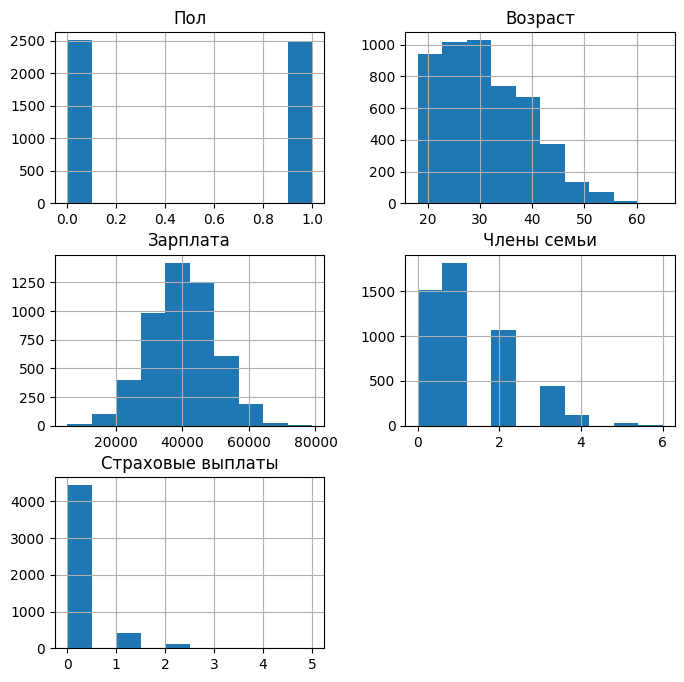

In [14]:
df.hist(figsize=(8,8));

In [15]:
df.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.002074,0.014910,-0.008991,0.010140
Возраст,0.002074,1.000000,-0.019093,-0.006692,0.651030
Зарплата,0.014910,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.010140,0.651030,-0.014963,-0.036290,1.000000


### Итог первого этапа

мы рассмотрели данные страховой компании, в ходе предобработки выяснилось:
* что они достаточно чистые и готовые к использованию; 
* целевой признак категориальный, и имеет более 2х видов; задачу не получится свести к бинарной классификации, судя по всему нам важен не только "есть или нет страховая выплата" но и ее вид.
* в категории признаков данные распределены хорошо, М и Ж примерно поровну, разброс зарплат по гауссу
* есть ожидаемый дисбаланс в целевом признаке, еслибы целью работы было разбиение выборки на рабочую и тестовую это следовало бы учесть и стратицифировать
* страховые выплаты очень сильно коррелируют с возрастом клиента

### Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** При перемножении матрицы признаков и любой обратимой матрицы предсказание и качество линейной регрессии не изменится

**Обоснование:** 


$$\require{cancel}$$
$$ w = (X^T X)^{-1} X^T y $$

$$ a = Xw $$

домножим на R (где R - рандомная обратимая матрица размерности равной количеству признаков)

$$ w2 = ((XR)^T (XR))^{-1} XR^T y $$

$$ a2 = XR (((XR^T) (XR))^{-1} XR^T y) $$

(используем следующие правила умножения матриц)
* ассоциативность $ A * B * C = A * (B * C) $
* $ (A * B)^T = B^T * A^T $
* $ (A * B)^{-1} = B^{-1} * A^{-1} $
* $ A * A^{-1} = E $,  единичная матрица


$$a2 = XR (~((XR)^T XR)^{-1} (XR)^T y)$$

раскроем скобки

$$а2 = XR ~(~(R^T X^T XR ~)~^{-1} R^T X^T y )$$





$$\require{cancel}$$

$$а_2 = XR ~(~((R^T X^T) XR ~)~^{-1} R^T X^T y )$$
$$а_2 = XR ~(R)^{-1} (X^T X)^{-1} (R^T)^{-1} R^T X^T y )$$    


$ R $ и $ R^{-1} $ превратятся в единичную матрицу, как и $ (R^T)^{-1} $ с $ R^{T} $

$$ a_2 = X \cancel{R} \cancel{R^{-1}} (X^T X)^{-1} \cancel{(R^T)^{-1}} \cancel{R^T} X^T y ) $$


$$a_2 = X (X^T X)^{-1} X^T y$$
из условия $w = (X^T X)^{-1} X^T y$, значит $a_2 = X w$

$a_2 = X w$, $a = X w$, $a = a_2$
что и требовалось доказать

### Алгоритм преобразования

**Алгоритм**

* выделим из загруженных данных фичи X и таргеты Y
* создадим случайную матрицу random_matrix с размерностью количества признаков
* проверим что она обратима, и сохраним обратную матрицу
* создадим и обучим линейную регрессию на неизмененных данных. Проверим ее качество метрикой r2
* создадим и обучим линейную регрессию на признаках умноженных на подготовленную случайную матрицу. Проверим ее качество метрикой r2
* сравним полученные показатели r2 обоих регрессий; они должны совпасть
* проверим что мы можем восстановить данные умножив модифицированную матрицу на заранее сохраненную обратную матрицу


**Обоснование**

мы проверили что умножение фичей на любую обратимую матрицу подходящей размерности качество предсказаний линейной регрессии не изменится, воспользуемся этим чтобы сохранить анонимность персональных данных клиентов при работе с ними, а так же иметь возможность при необходимости их восстановить

### Проверка алгоритма

фичи, таргет

In [16]:
X = df.drop('Страховые выплаты', axis=1)
X = np.array(X)

In [17]:
X

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]], dtype=int64)

In [18]:
Y = df['Страховые выплаты']
Y = np.array(Y)

In [19]:
Y

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

создадим случайную матрицу и проверим ее обратимость

In [20]:
random_matrix = STATE.normal(size=(4, 4))

In [21]:
random_matrix

array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ],
       [ 1.96578057,  1.39340583,  0.09290788,  0.28174615],
       [ 0.76902257,  1.24643474,  1.00718936, -1.29622111],
       [ 0.27499163,  0.22891288,  1.35291684,  0.88642934]])

In [22]:
inverted_matrix = np.linalg.inv(random_matrix)

In [23]:
inverted_matrix

array([[-1.31136747,  0.3921804 ,  0.18868055, -0.67088287],
       [ 1.75872714,  0.14106138, -0.17773045,  0.79787127],
       [-0.41702659, -0.22854768,  0.3550602 ,  0.33039819],
       [ 0.58912996,  0.19073027, -0.5545481 ,  0.6259302 ]])

создадим линейную регрессию для начальных признаков

In [24]:
model = LinearRegression()

In [25]:
model.fit(X,Y)
pred = model.predict(X)
r2 = r2_score(Y, pred)
print('r2', r2)

r2 0.42494550286668


создадим линейную регрессию для измененных анонимных данных

In [26]:
X_mod = (X @ random_matrix)
model.fit(X_mod, Y)
pred_mod = model.predict(X_mod)
r2_mod = r2_score(Y, pred_mod)
print('r2 modif', r2_mod)

r2 modif 0.424945502866681


r2 совпадает, успех!

удостоверимся что при умножении измененных данных на матрицу обратную той, с помощью которой модифицировали - данные получится восстановить

In [27]:
back_from_ashes = X_mod @ inverted_matrix

In [28]:
back_from_ashes_df = pd.DataFrame(data = back_from_ashes, columns=['Пол','Возраст','Зарплата','Члены семьи'])

In [29]:
back_from_ashes_df

,Пол,Возраст,Зарплата,Члены семьи
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-6.449658e-12,46.0,38000.0,1.000000e+00
2,1.576164e-12,29.0,21000.0,-1.828262e-12
3,-9.028180e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.589574e-12
...,...,...,...,...
4995,-8.138865e-12,28.0,35700.0,2.000000e+00
4996,1.130693e-11,34.0,52400.0,1.000000e+00
4997,-7.963313e-12,20.0,33900.0,2.000000e+00
4998,1.000000e+00,22.0,32700.0,3.000000e+00


In [30]:
back_from_ashes_df = round(back_from_ashes_df)

In [31]:
back_from_ashes_df

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,-0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,-0.0
...,...,...,...,...
4995,-0.0,28.0,35700.0,2.0
4996,0.0,34.0,52400.0,1.0
4997,-0.0,20.0,33900.0,2.0
4998,1.0,22.0,32700.0,3.0


In [32]:
df_features_original = df.drop('Страховые выплаты', axis=1)

In [33]:
mean_absolute_error(df_features_original, back_from_ashes_df)

0.0

данные получилось восстановить без отклонения от начальных

## Итоги

Мы разработали метод преобразования персональных данных, позволяющий защитить и анонимизировать их без потери качества предсказаний линейной регресии.

В ходе работы мы:
* загрузили и подготовили данные
* обосновали теоритическую возможность защиты данных с помощью умножения на случайную обратимую матрицу
* подготовили алгоритм реализации задачи
* проверили что качество линейной регрессии не отличается до и после преобразования на выбранной метрике r2
* проверили что зная матрицу обратную кодирующей - данные можно вернуть в первозданный вид